# Ising model on a nearest neighbor random graph
This is another example including Ising model where the underlying graph is a random nearest neighbor graph on plane. 

In [1]:
using Pkg, Revise
Pkg.activate(joinpath(@__DIR__, "../.."))
using EasyABM

  Activating project at `~/Documents/EasyABM`
[ Info: Precompiling EasyABM [2ab8e4d3-e1e9-4248-86a3-8419d2d242e9]


WebIO._IJuliaInit()

## Step 1: Create Model

In this model we will work solely with the graph and won't need agents. We initially create an empty graph and then create our model as follows. 

In [2]:
graph = dynamic_simple_graph(0)

SimplePropGraph
vertices: Int64[]
edges: 


In [3]:
model = create_graph_model(graph, temp = 2.0, coupl = 2.5, nns = 5)

EasyABM GraphModel{EasyABM.MortalType, EasyABM.StaticType, EasyABM.SimGType}: In a {EasyABM.MortalType, EasyABM.StaticType} model graph topology can change and agents number is fixed.


## Step 2: Initialise the model

 In the `initialiser!` function we create a list of n = 500 random points in the plane and fill our graph with n nodes and set the position of ith node to the ith random point. We then link each node to its `nns` number of nearest neighbors and randomly set each node's color to either `cl"black"` or `cl"white"` and set spin value to +1 for `cl"black"` nodes and -1 for `cl"white"` nodes. In the `init_model!` function, the argument `props_to_record` specifies the nodes properties which we want to record during model run.  

In [4]:
using NearestNeighbors

In [5]:
const n=100;

In [6]:
vecs = rand(2, n) .* 10
kdtree = KDTree(vecs,leafsize=4)

function initialiser!(model)
    flush_graph!(model) # deletes all nodes and edges
    add_nodes!(n, model, color = cl"black", spin =1) # adds n nodes to model's graph with all the nodes having color black and spin 1
    for i in 1:n 
        model.graph.nodesprops[i].pos = (vecs[1,i], vecs[2,i]) # set positions of nodes in the 2d plane
        indices, _ = knn(kdtree, vecs[:,i], model.parameters.nns, true) # indices of nearest neighboring vectors
        for j in indices
            if j!=i
                create_edge!(i,j, model)
            end
        end
        if rand()<0.5
            model.graph.nodesprops[i].spin = 1
            model.graph.nodesprops[i].color = cl"black"
        else
            model.graph.nodesprops[i].spin = -1
            model.graph.nodesprops[i].color = cl"white"
        end
    end
end

initialiser! (generic function with 1 method)

In [7]:
init_model!(model, initialiser= initialiser!, props_to_record = Dict("nodes"=>Set([:color, :spin]))) 

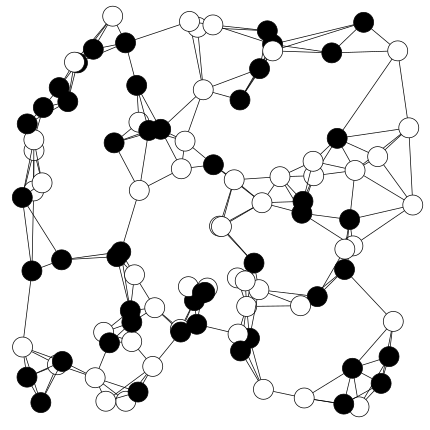

In [8]:
draw_graph(model.graph)

## Step 3: Defining the step_rule! and running the model

In this step we implement the step logic of the Ising model in the `step_rule!` function and run the model for 100 steps. At each step of the simulation we take 100 Monte Carlo steps, where in each Monte Carlo step a node is selected at random and its spin and color values are flipped if the Ising energy condition is satisfied. 

In [9]:
function step_rule!(model)
    for i in 1:100
        random_node = rand(1:n)
        spin = model.graph.nodesprops[random_node].spin
        nbr_nodes = neighbor_nodes(random_node, model)
        de = 0.0
        for node in nbr_nodes
            nbr_spin = model.graph.nodesprops[node].spin
            de += spin*nbr_spin
        end
        de = 2*model.parameters.coupl * de
        if (de < 0) || (rand() < exp(-de/model.parameters.temp))
            model.graph.nodesprops[random_node].spin = - spin
            model.graph.nodesprops[random_node].color = spin == -1 ? cl"black" : cl"white"
        end
    end
end

step_rule! (generic function with 1 method)

In [10]:
run_model!(model, steps = 100, step_rule = step_rule!)

## Step 4: Visualisation
In order to draw the model at a specific frame, say 4th, one can do

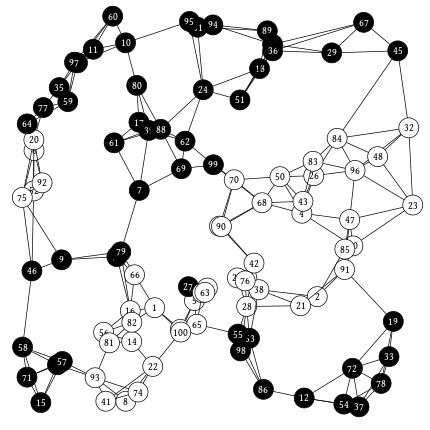

In [11]:
draw_frame(model, frame = 4, mark_nodes=true)

If one wants to see the animation of the model run, it can be done as 

In [12]:
animate_sim(model, mark_nodes=true)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["time"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 101, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(51), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x00007fd9d47e1140, Task (runnable) @0x00007fd9d47e1140), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 0, 0)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n 

After defining the `step_rule!` function we can also choose to create an interactive application (which currently works in Jupyter with WebIO installation) as 

In [13]:
run_model!(model, steps = 1, step_rule = step_rule!)

In [14]:
create_interactive_app(model, initialiser= initialiser!,
    props_to_record = Dict("nodes"=>Set([:color, :spin])),
    step_rule= step_rule!,
    model_controls=[(:temp, "slider", 0.05:0.05:5.0), 
        (:coupl, "slider", 0.01:0.1:5.0),
        (:nns, "slider", 2:10)],
    node_plots = Dict("magnetisation"=> x -> x.spin),
    frames=100, mark_nodes=true) 

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["time"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 100, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(1), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x00007fd964729dc0, Task (runnable) @0x00007fd964729dc0), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (8, 0, 0)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n  

##### Step 4: Fetch Data 

In this step we fetch the data of average spin of nodes (also called magnetisation) and plot the result as follows.

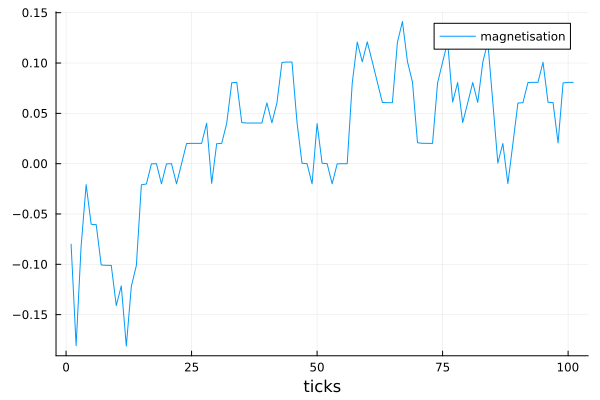

Row,magnetisation
,Float64
1,-0.08
2,-0.1808
3,-0.081808
4,-0.0208181
5,-0.0602082
6,-0.0606021
7,-0.100606
8,-0.101006
9,-0.10101


In [15]:
df = get_nodes_avg_props(model, node -> node.spin, labels=["magnetisation"], plot_result = true)